In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import numpy as np

import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
import copy
import pickle
import argparse
retraining_epochs = 50

In [3]:
def retrain_model(alpha, beta, tau, temp, mixtures, model_name, data_size, model_save_dir = "", scaling = False):
    if(data_size == 'search'):
        train_dataset = search_retrain_data
        val_data_full = Variable(search_validation_data(fetch='data')).cuda()
        val_labels_full = Variable(search_validation_data(fetch='labels')).cuda()
        (x_start, x_end) = (40000, 50000)
    if(data_size == 'full'):
        train_dataset = train_data
        (x_start, x_end) = (0, 60000)
    test_data_full = Variable(test_data(fetch='data')).cuda()
    test_labels_full = Variable(test_data(fetch='labels')).cuda()
        
    model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
    model = torch.load(model_load_dir + model_file + '.m').cuda()
        
    if temp == 0:
        loader = torch.utils.data.DataLoader(dataset=train_dataset(), batch_size=batch_size, shuffle=True)
    else:
        output = torch.load("{}{}_targets/{}.out.m".format(model_load_dir, model_file, "fc2" if "SWS" in model.name else "fc3"))[x_start:x_end]###
        output = (nn.Softmax(dim=1)(output/temp)).data
        dataset = torch.utils.data.TensorDataset(train_dataset(fetch='data'), output)
        loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()###
    
    exp_name = "{}_a{}_b{}_r{}_t{}_m{}_kdT{}_{}".format(model.name, alpha, beta, retraining_epochs, tau, int(mixtures), int(temp), data_size)
    gmp = GaussianMixturePrior(mixtures, [x for x in model.parameters()], 0.99, ab = (alpha, beta), scaling = scaling)
    gmp.print_batch = False

    opt = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 5e-4},
        {'params': [gmp.means], 'lr': 1e-4},
        {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}])#log precisions and mixing proportions

    for epoch in range(retraining_epochs):
        model, loss = retrain_sws_epoch(model, gmp, opt, criterion, loader, tau, temp)

        if (trueAfterN(epoch, 10)):
            test_acc = test_accuracy(test_data_full, test_labels_full, model)
            print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))
            show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)###
            
        if (data_size == 'search' and (epoch>12) and trueAfterN(epoch, 2)):
            val_acc = float((test_accuracy(val_data_full, val_labels_full, model)[0]))
            if (val_acc < 50.0):
                print ("Terminating Search - Epoch: {} - Val Acc: {:.2f}".format(epoch, val_acc))
                break
    #if(model_save_dir!=""):
    #    torch.save(model, model_save_dir + '/mnist_retrain_{}.m'.format(exp_name))
    #    with open(model_save_dir + '/mnist_retrain_{}_gmp.p'.format(exp_name),'wb') as f:
    #        pickle.dump(gmp, f)
    
    test_accuracy_pre = float((test_accuracy(test_data_full, test_labels_full, model)[0]))
    val_accuracy_pre = 0 if (data_size != 'search') else float((test_accuracy(val_data_full, val_labels_full, model)[0]))
    
    model_prune = copy.deepcopy(model)
    model_prune.load_state_dict(sws_prune_l2(model_prune, gmp))
    prune_acc = (test_accuracy(test_data_full, test_labels_full, model_prune))
    test_accuracy_prune = float((test_accuracy(test_data_full, test_labels_full, model_prune)[0]))
    val_accuracy = 0 if (data_size != 'search') else float((test_accuracy(val_data_full, val_labels_full, model_prune)[0]))
    sparsity = (special_flatten(model_prune.state_dict())==0).sum()/(special_flatten(model_prune.state_dict())>0).numel() * 100
    print('Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}'
          .format(test_accuracy_pre, val_accuracy_pre, test_accuracy_prune, val_accuracy, sparsity))
    
        
    return model, gmp###

### Measuring Variance in Results

In [4]:
with open("../search/sobol_search.p", "rb") as handle:
    params = pickle.load(handle)
i = 240
print ("exp:{} mean: {}, var: {}, tau: {}, temp: {}, mixtures: {}".format(i, params['mean'][i], params['var'][i], params['tau'][i], params['temp'][i], int(params['mixtures'][i])))
mean = float(params['mean'][i])
var = float(params['var'][i])
beta = mean/var
alpha = mean * beta

exp:240 mean: 0.10181517217181825, var: 0.1034304555503225, tau: 6.479230606842127e-07, temp: 19.0, mixtures: 9


In [9]:
for j in range(0,10):
    _, _ = retrain_model(alpha, beta, float(params['tau'][i]), params['temp'][i], int(params['mixtures'][i]), 'SWSModel', 'search', (5e-4, 1e-4, 3e-3), "", False)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 25. Test Accuracy: 98.63
Epoch: 50. Test Accuracy: 98.70
Retrain Test: 98.70, Retrain Validation: 98.52, Prune Test: 98.66, Prune Validation: 98.41, Prune Sparsity: 70.09
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 25. Test Accuracy: 98.74
Epoch: 50. Test Accuracy: 98.69
Retrain Test: 98.69, Retrain Validation: 98.67, Prune Test: 98.44, Prune Validation: 98.37, Prune Sparsity: 71.17
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 25. Test Accuracy: 98.80
Epoch: 50. Test Accuracy: 98.70
Retrain Test: 98.70, Retrain Validation: 98.57, Prune Test: 98.64, Prune Validation: 98.44, Prune Sparsity: 68.92
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Ep

### New KD

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 98.73


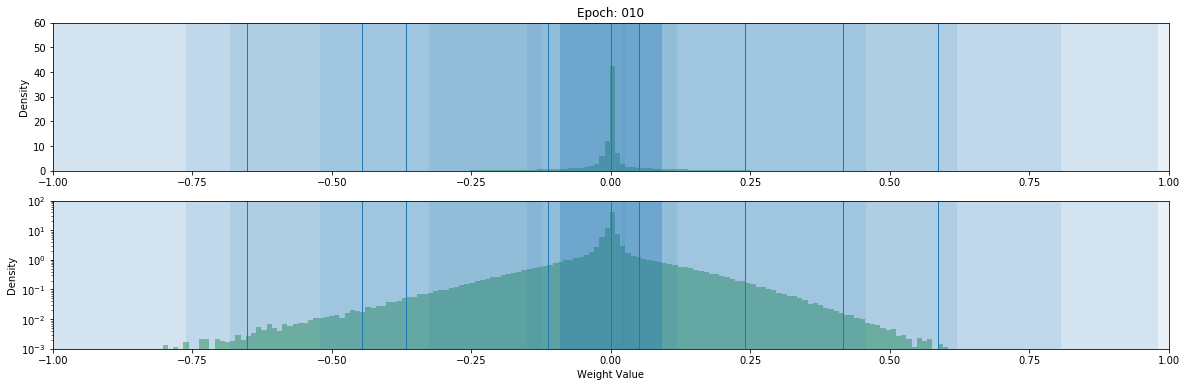

Epoch: 20. Test Accuracy: 98.66


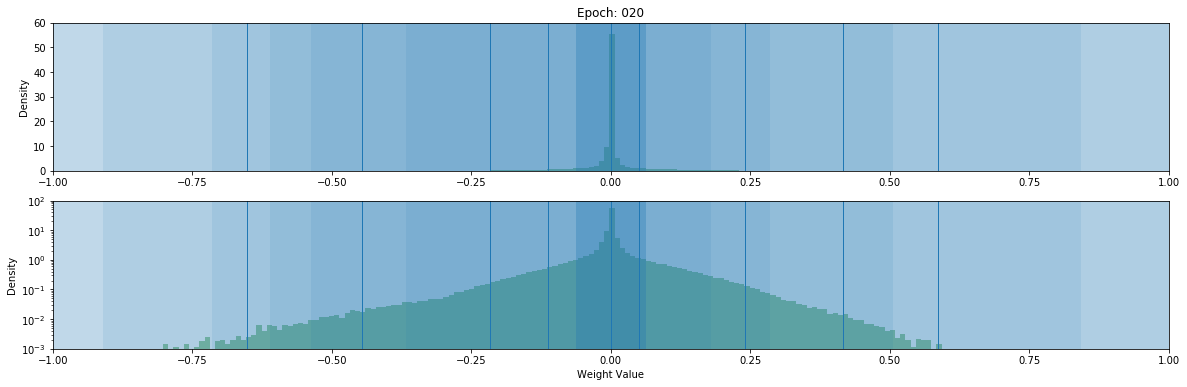

Epoch: 30. Test Accuracy: 98.28


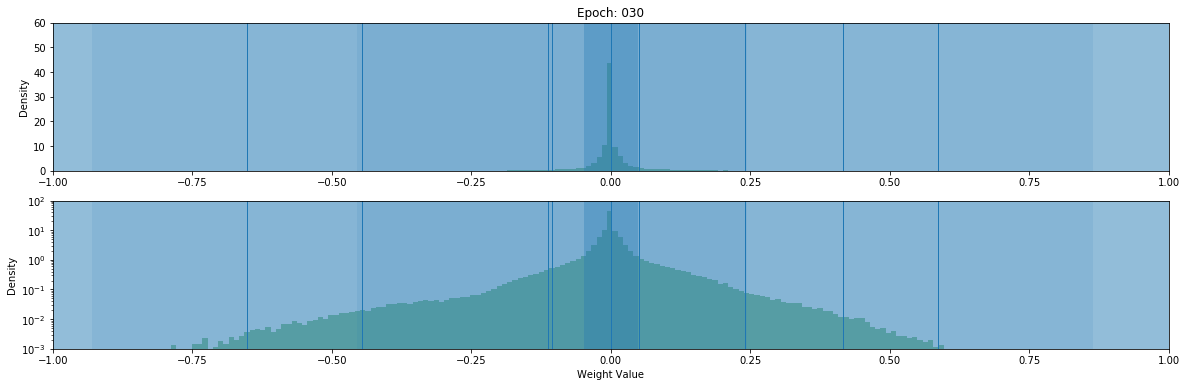

Epoch: 40. Test Accuracy: 98.52


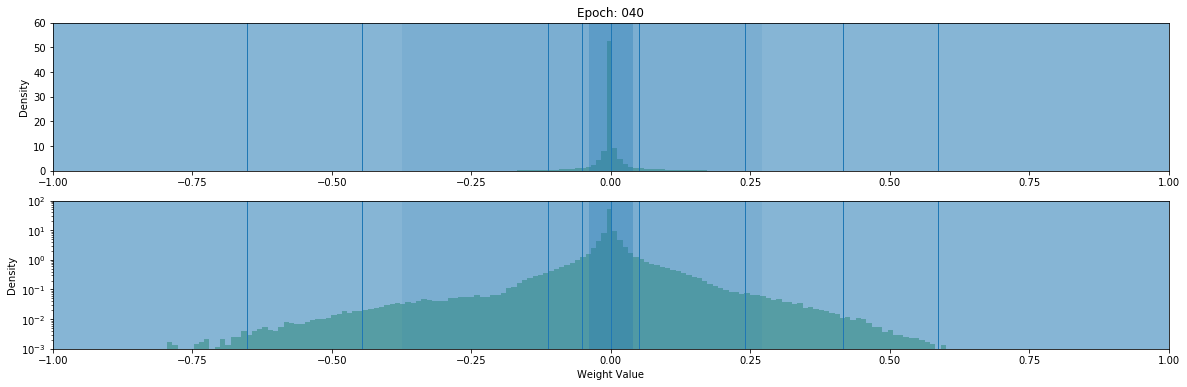

Epoch: 50. Test Accuracy: 98.08


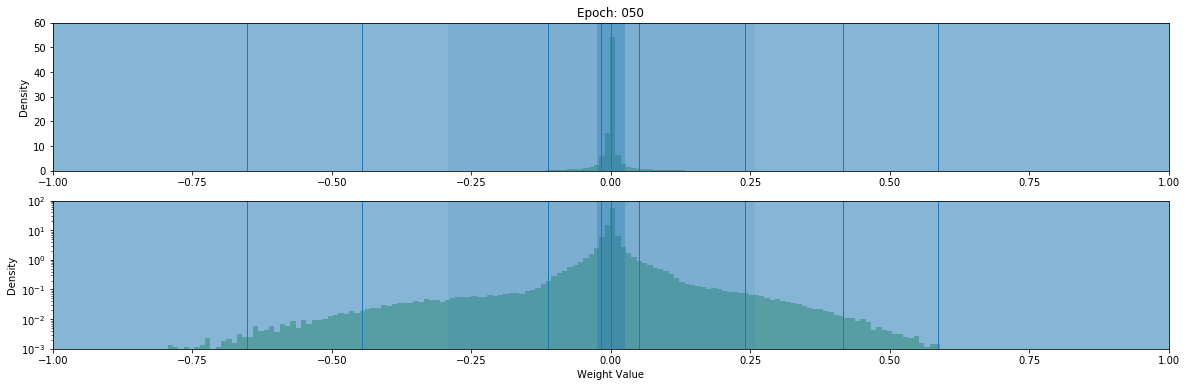

Retrain Test: 98.08, Retrain Validation: 98.17, Prune Test: 98.07, Prune Validation: 98.04, Prune Sparsity: 71.80


In [34]:
_, _ = retrain_model(alpha, beta, float(params['tau'][i]), params['temp'][i], int(params['mixtures'][i]), 'SWSModel', 'search', "", False)

### Running over full dataset

#### Search 10K Parameters

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225


../src/utils_model.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = nn.Softmax()(model(images)/temp)


Epoch: 10. Test Accuracy: 98.27


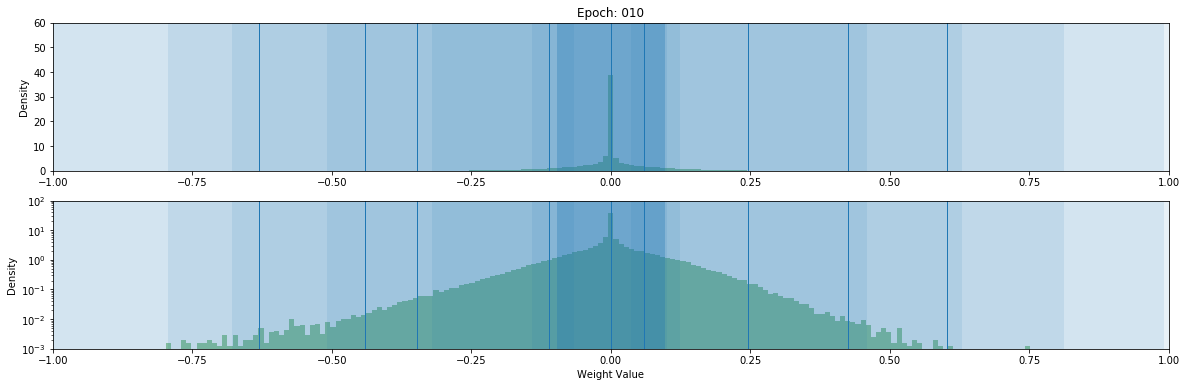

Epoch: 20. Test Accuracy: 98.24


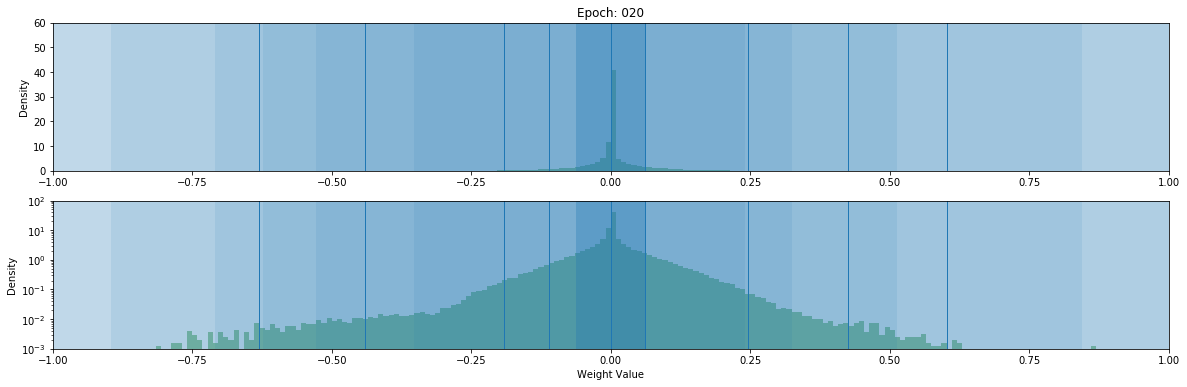

Epoch: 30. Test Accuracy: 98.24


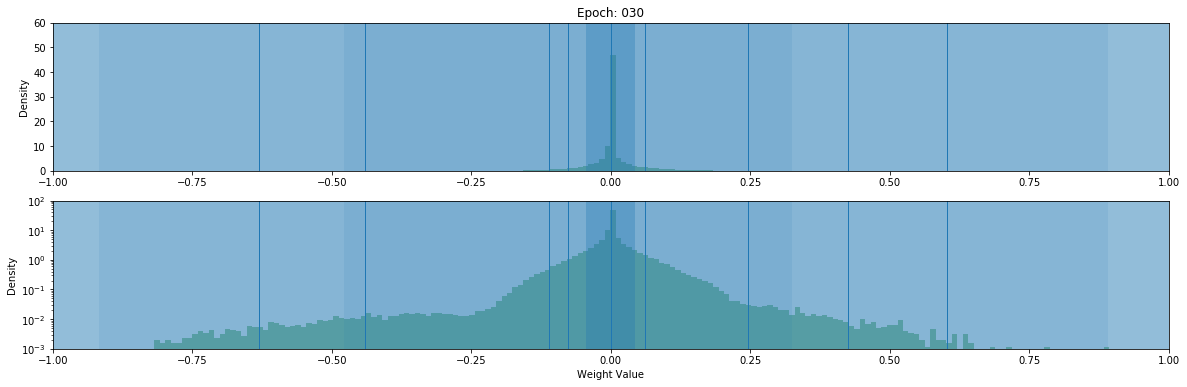

Epoch: 40. Test Accuracy: 98.30


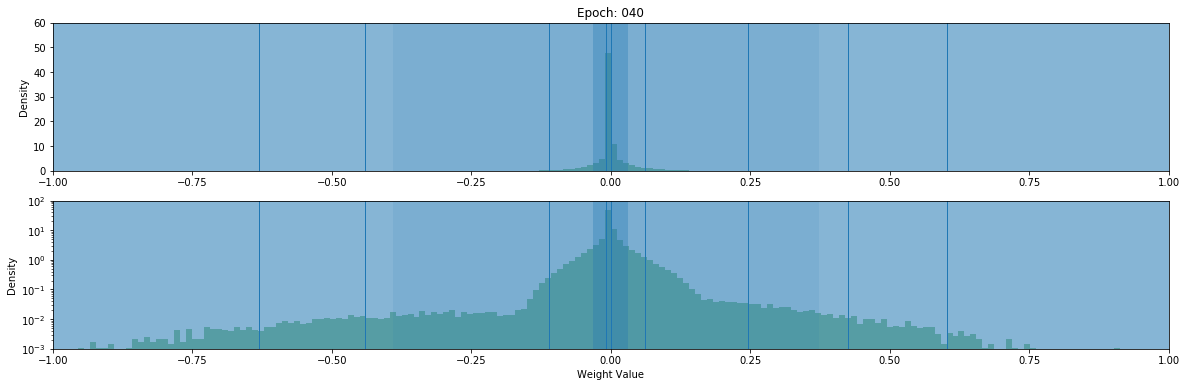

Epoch: 50. Test Accuracy: 98.21


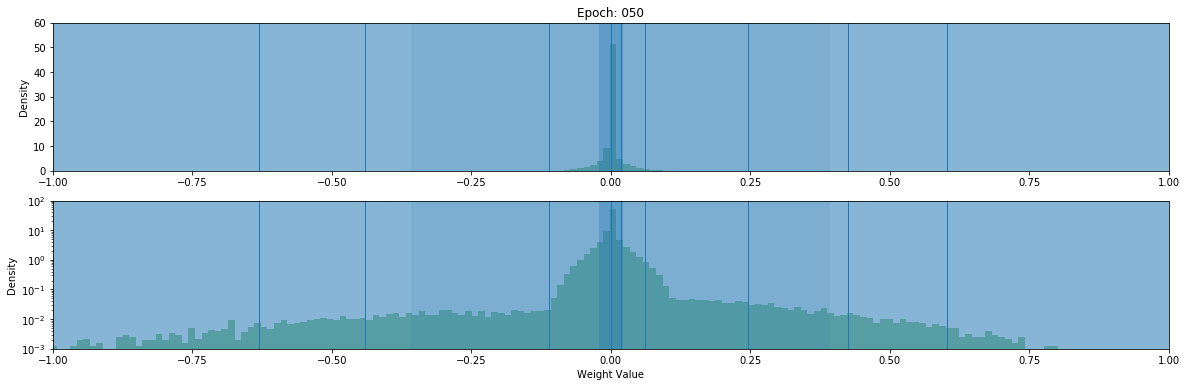

Retrain Test: 98.21, Retrain Validation: 98.21, Prune Test: 94.40, Prune Validation: 94.55, Prune Sparsity: 80.67


In [20]:
model, gmp = retrain_model(alpha, beta, float(params['tau'][i]), params['temp'][i], int(params['mixtures'][i]), 'LeNet_300_100', 'search', "", False)

#### Full 60K Parameters

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 98.42


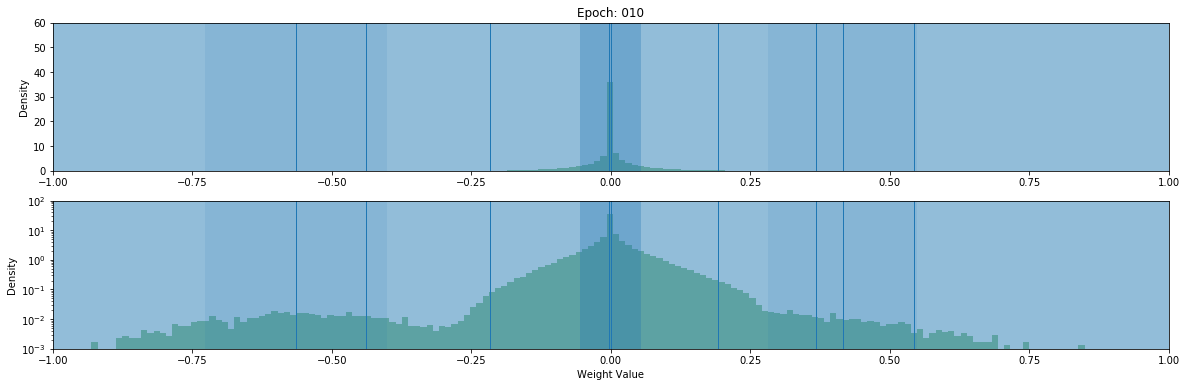

Epoch: 20. Test Accuracy: 98.37


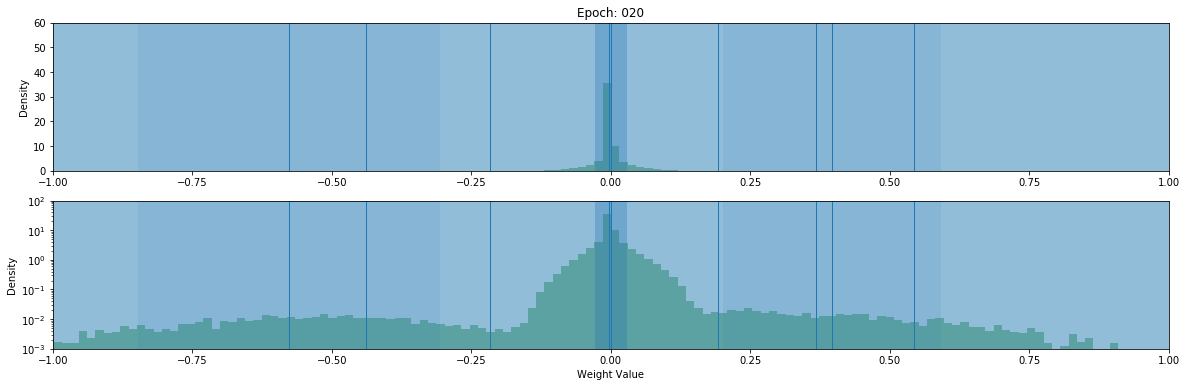

Epoch: 30. Test Accuracy: 98.42


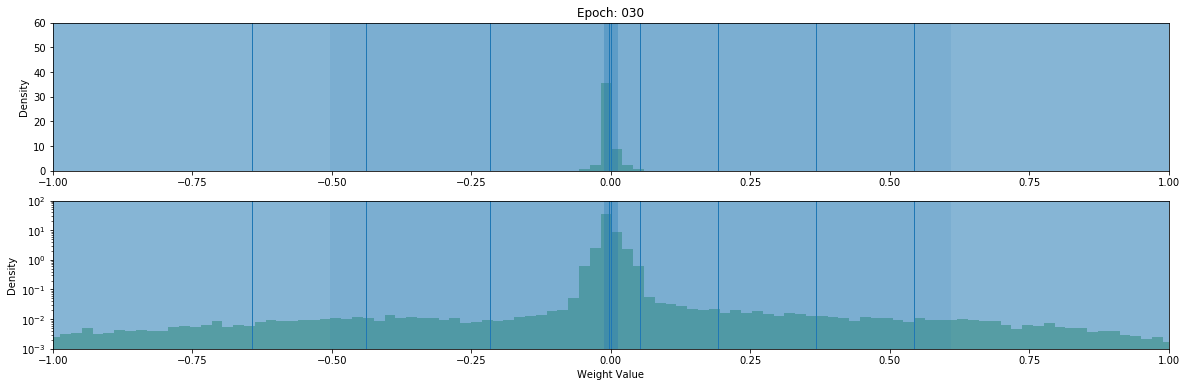

Epoch: 40. Test Accuracy: 98.18


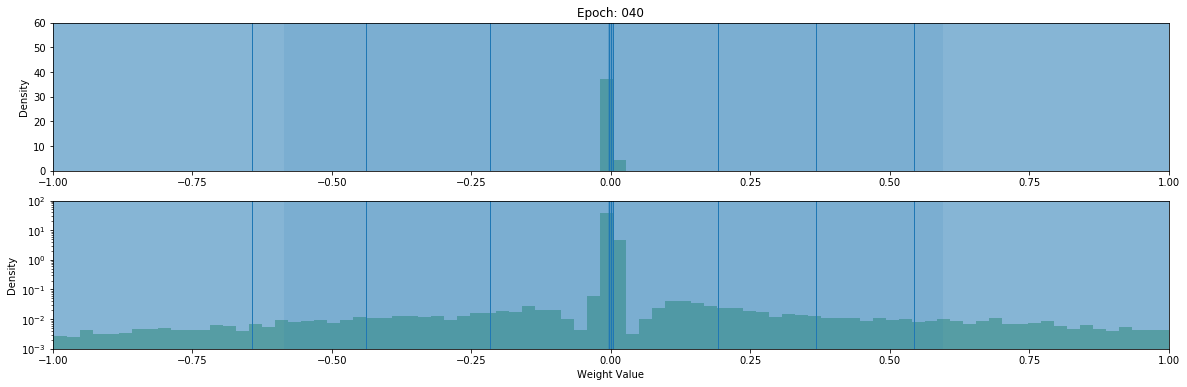

Epoch: 50. Test Accuracy: 98.25


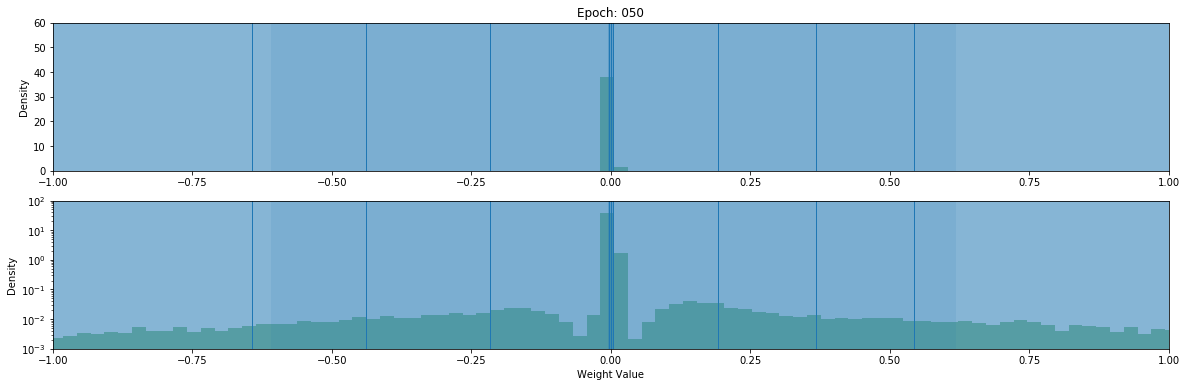

Retrain Test: 98.25, Retrain Validation: 0.00, Prune Test: 96.87, Prune Validation: 0.00, Prune Sparsity: 71.82


In [24]:
model, gmp = retrain_model(alpha, beta, float(params['tau'][i]), params['temp'][i], int(params['mixtures'][i]), 'LeNet_300_100', 'full', "", False)

#### Search 10K Parameters w/ Scaling

In [16]:
model, gmp = retrain_model(alpha, beta, float(params['tau'][i]), params['temp'][i], int(params['mixtures'][i]), 'SWSModel', 'search', (5e-4, 1e-4, 3e-3), "", True)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 25. Test Accuracy: 98.74
Epoch: 50. Test Accuracy: 98.55
Retrain Test: 98.55, Retrain Validation: 98.50, Prune Test: 98.52, Prune Validation: 98.41, Prune Sparsity: 71.14


#### Full 60K Parameters w/ Scaling

In [17]:
model, gmp = retrain_model(alpha, beta, float(params['tau'][i]), params['temp'][i], int(params['mixtures'][i]), 'SWSModel', 'full', (5e-4, 1e-4, 3e-3), "", True)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 25. Test Accuracy: 98.79
Epoch: 50. Test Accuracy: 99.00
Retrain Test: 99.00, Retrain Validation: 0.00, Prune Test: 98.51, Prune Validation: 0.00, Prune Sparsity: 78.08


### Effect of Temperature

TEMP: 0
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 97.78


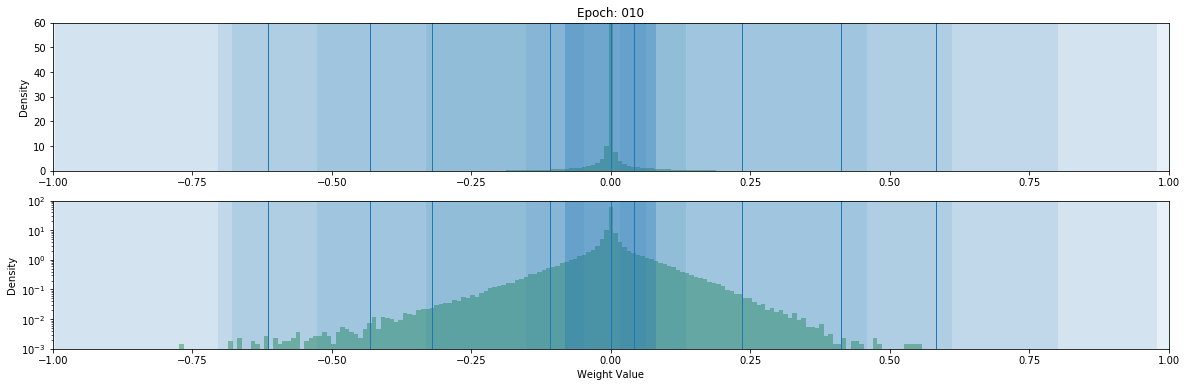

Epoch: 20. Test Accuracy: 97.72


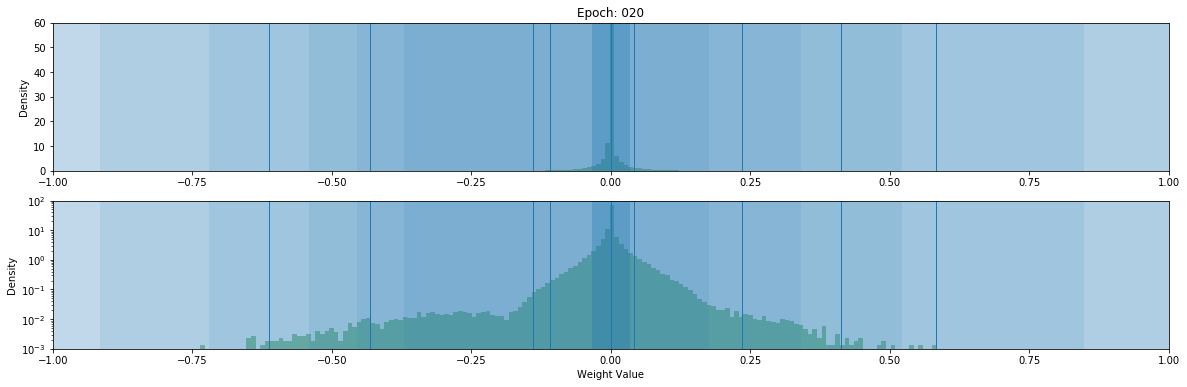

Epoch: 30. Test Accuracy: 97.06


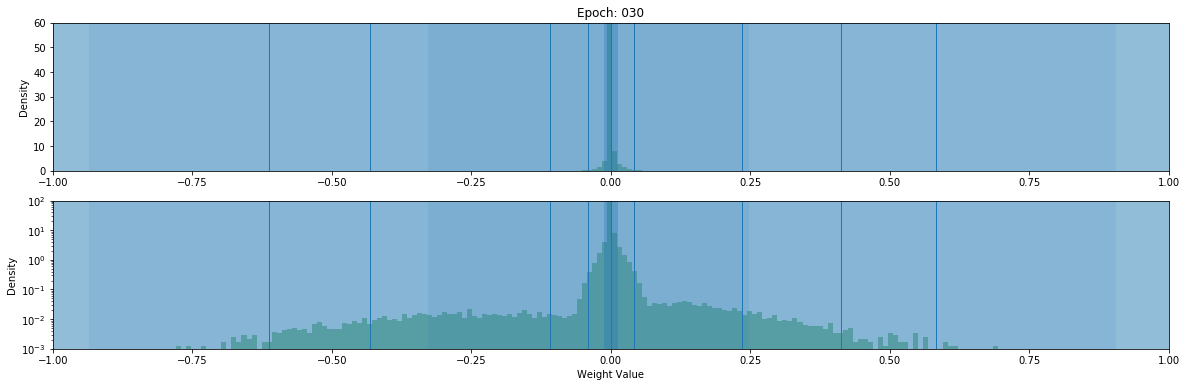

Epoch: 40. Test Accuracy: 96.48


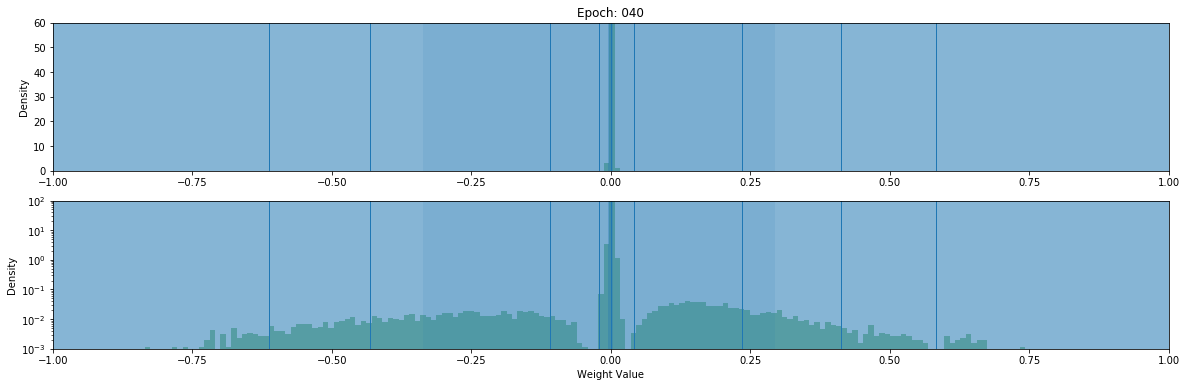

Epoch: 50. Test Accuracy: 96.55


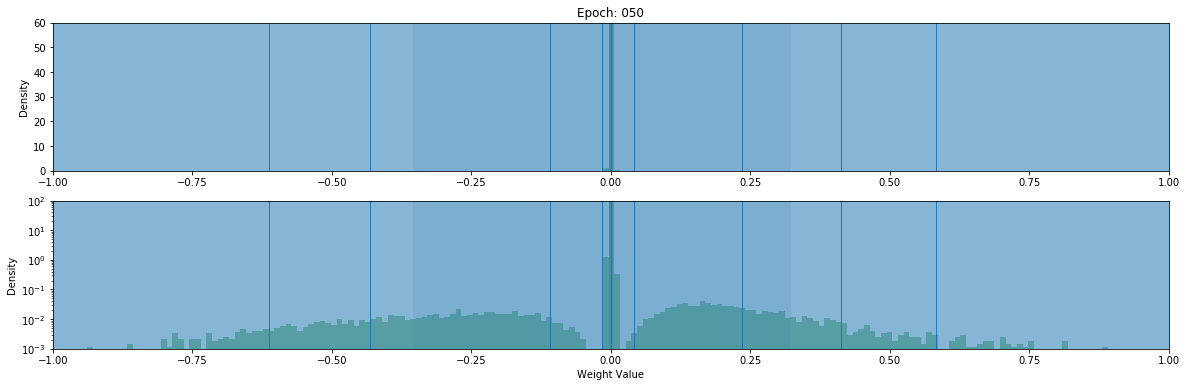

Retrain Test: 96.55, Retrain Validation: 96.48, Prune Test: 86.61, Prune Validation: 87.35, Prune Sparsity: 98.53
TEMP: 1
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 98.05


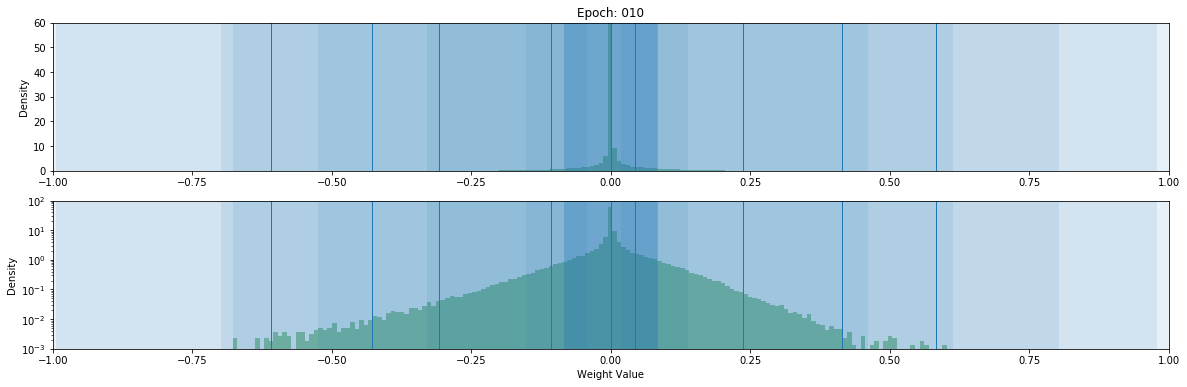

Epoch: 20. Test Accuracy: 98.02


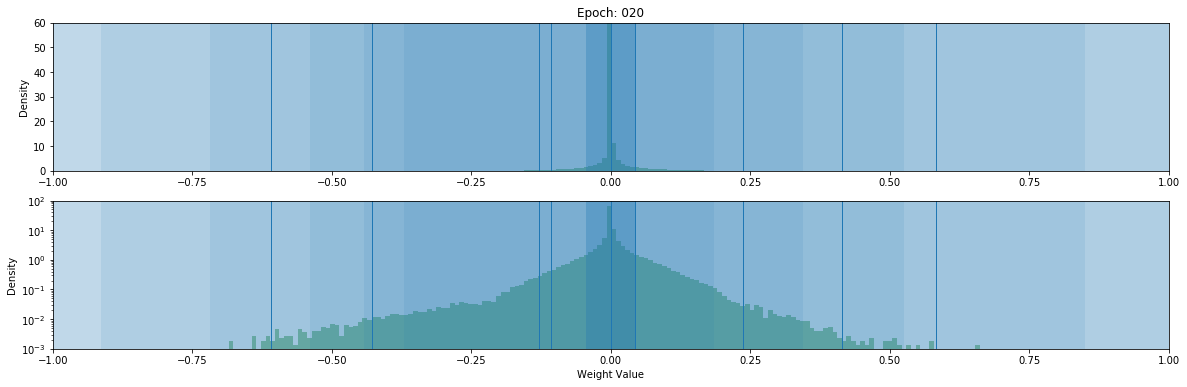

Epoch: 30. Test Accuracy: 97.68


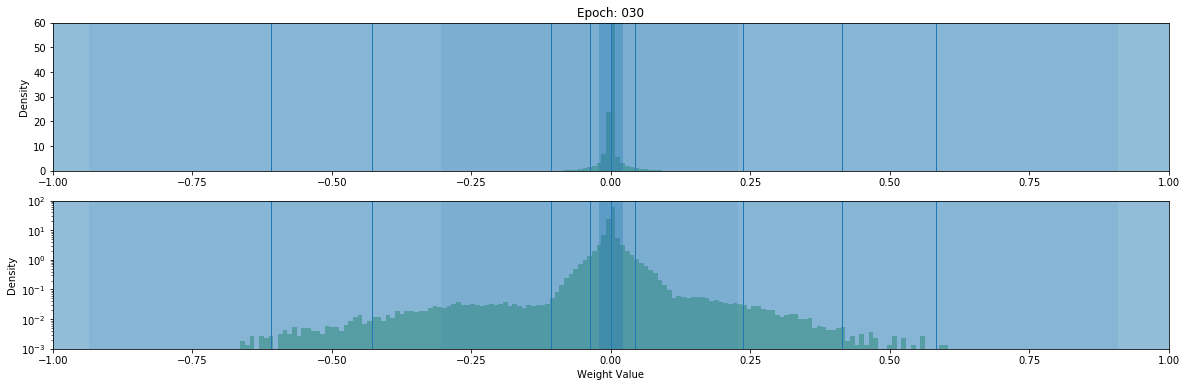

Epoch: 40. Test Accuracy: 97.23


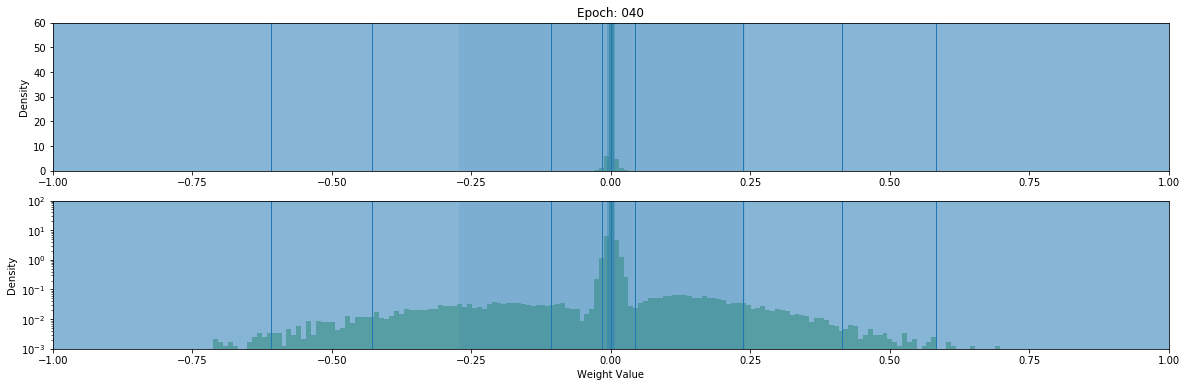

Epoch: 50. Test Accuracy: 96.97


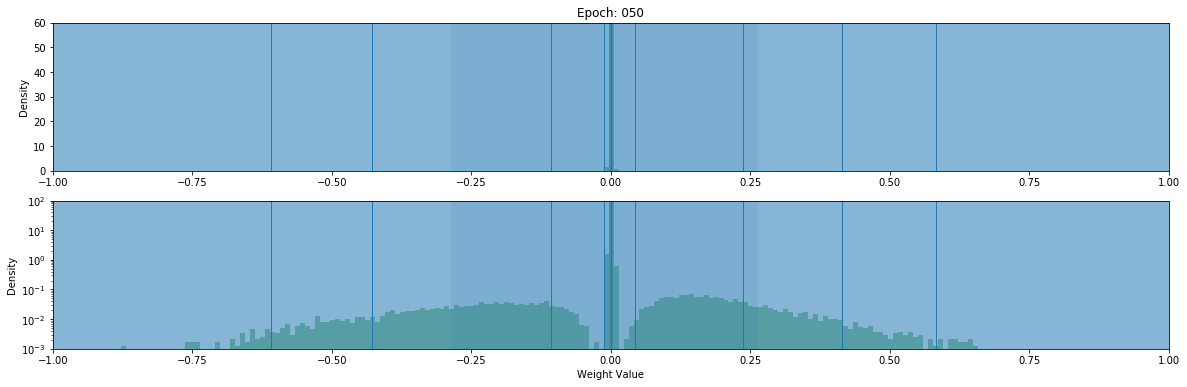

Retrain Test: 96.97, Retrain Validation: 96.77, Prune Test: 94.14, Prune Validation: 93.91, Prune Sparsity: 97.52
TEMP: 5
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 98.24


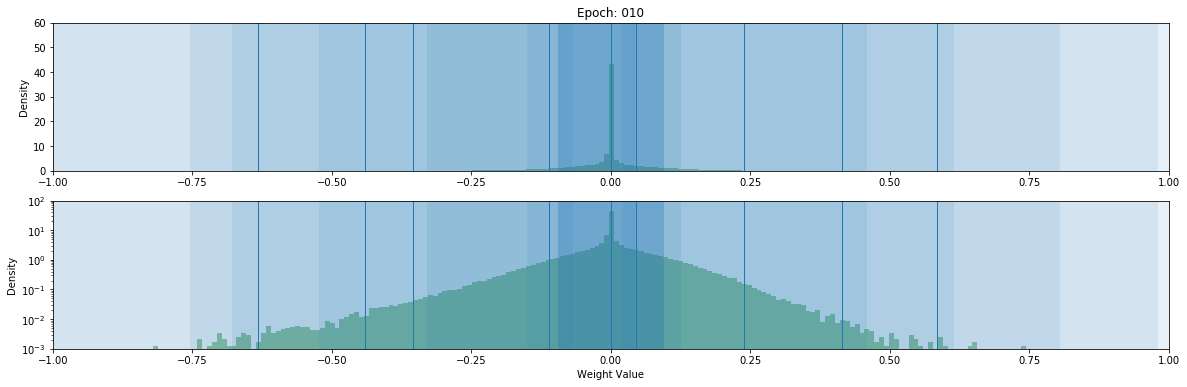

Epoch: 20. Test Accuracy: 98.32


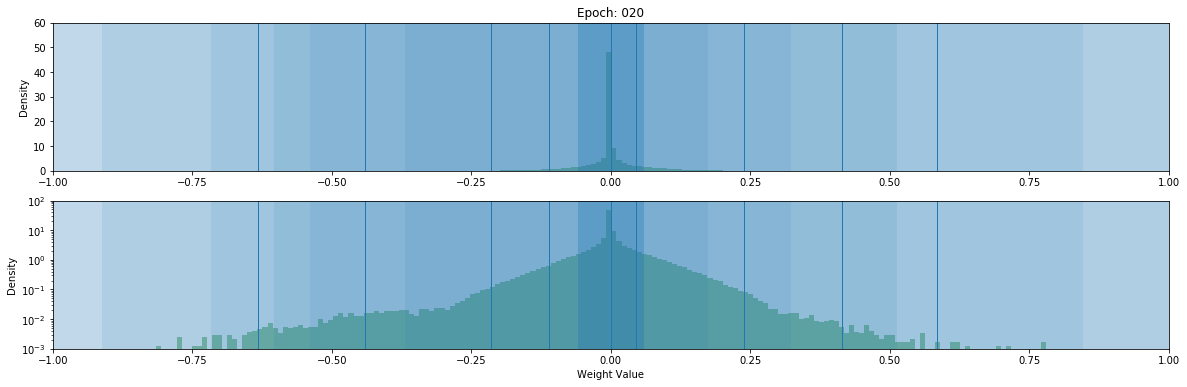

Epoch: 30. Test Accuracy: 98.08


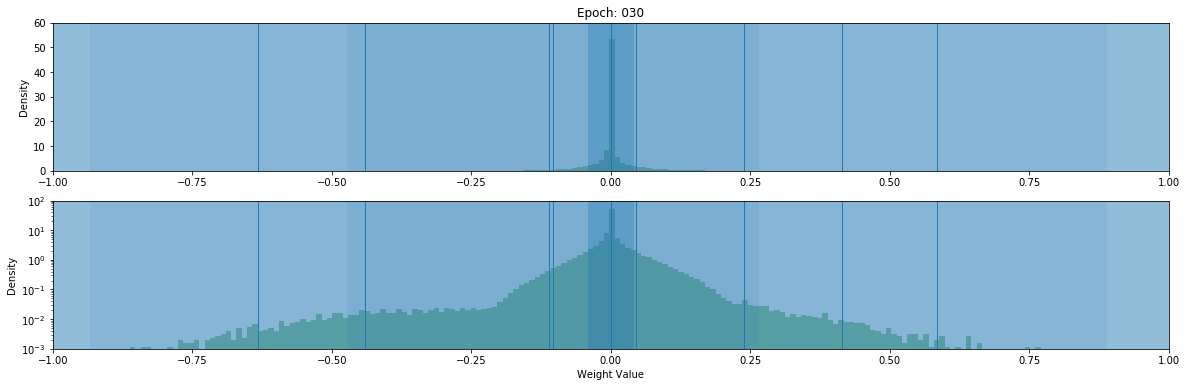

Epoch: 40. Test Accuracy: 98.08


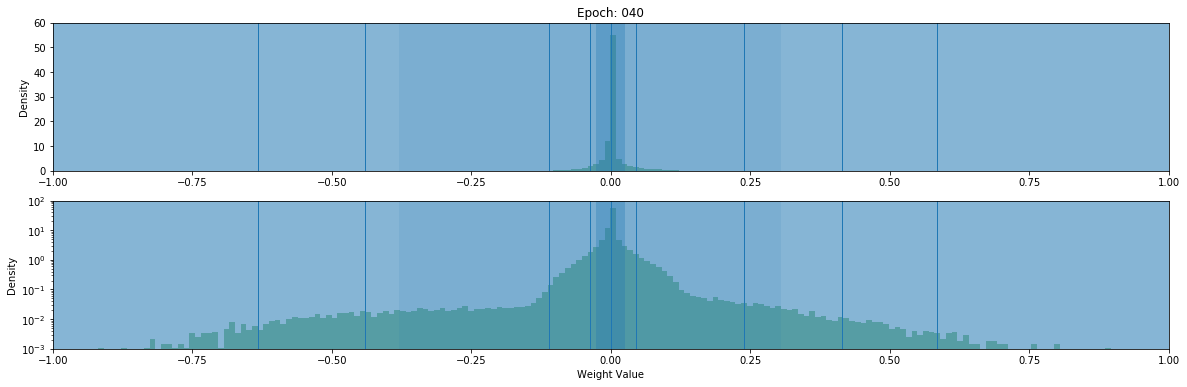

Epoch: 50. Test Accuracy: 97.87


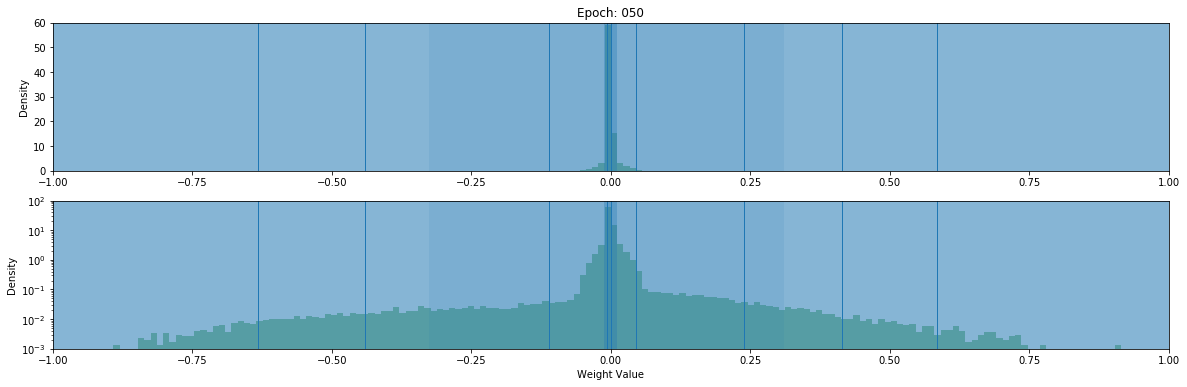

Retrain Test: 97.87, Retrain Validation: 97.83, Prune Test: 94.17, Prune Validation: 93.82, Prune Sparsity: 93.44
TEMP: 10
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 98.29


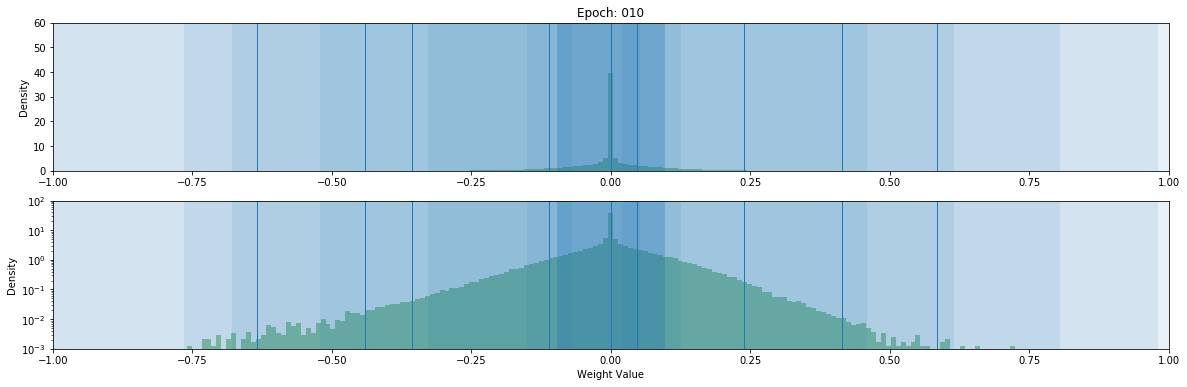

Epoch: 20. Test Accuracy: 98.25


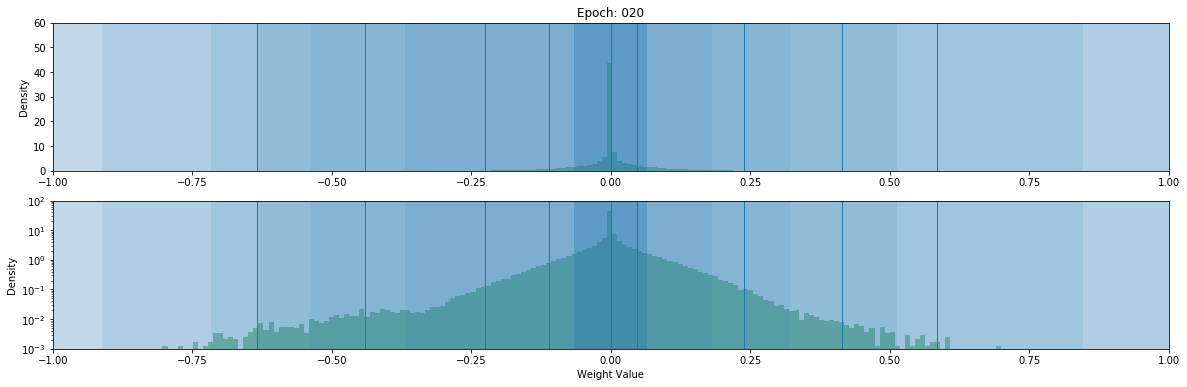

Epoch: 30. Test Accuracy: 98.20


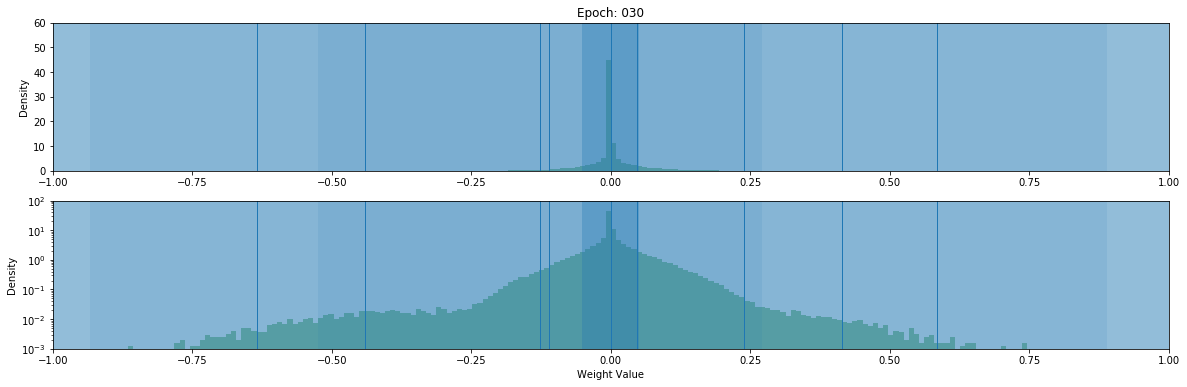

Epoch: 40. Test Accuracy: 98.19


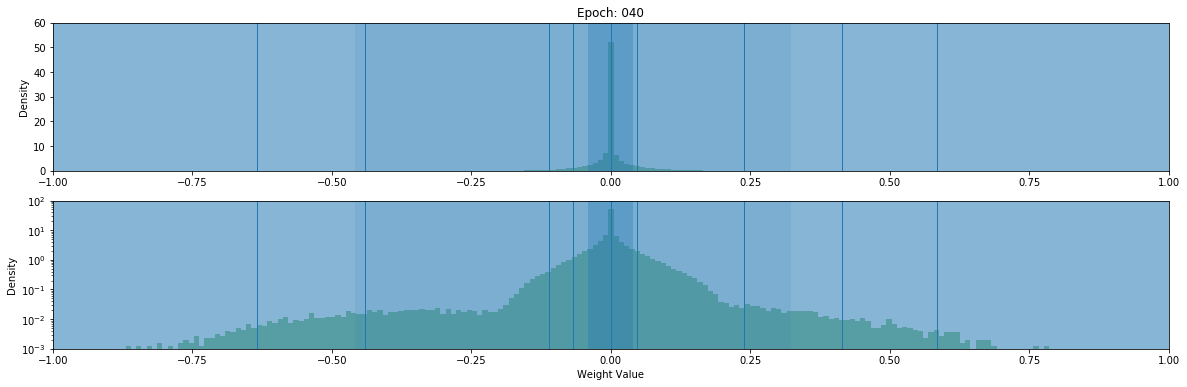

Epoch: 50. Test Accuracy: 98.15


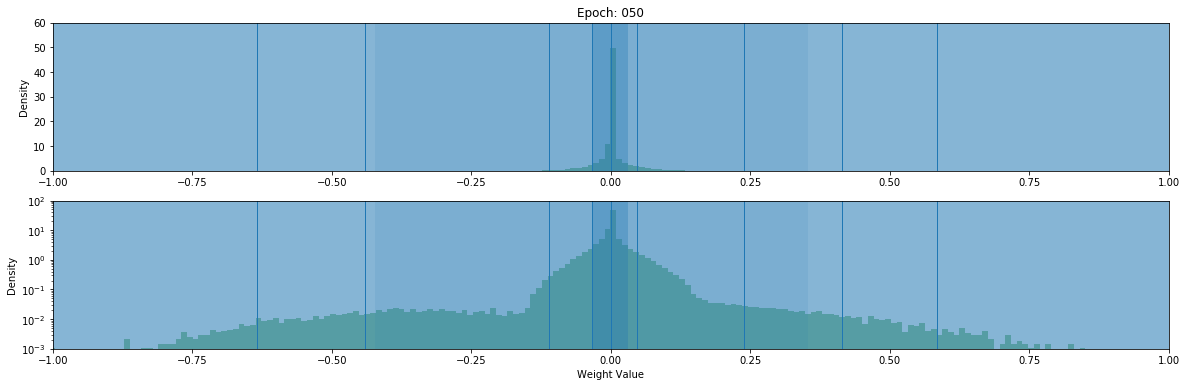

Retrain Test: 98.15, Retrain Validation: 98.22, Prune Test: 97.59, Prune Validation: 97.36, Prune Sparsity: 71.74
TEMP: 25
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 98.24


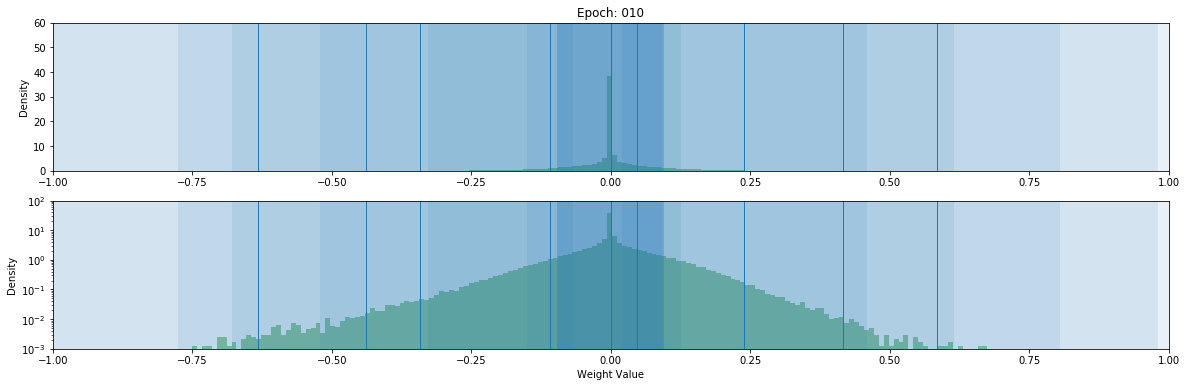

Epoch: 20. Test Accuracy: 98.21


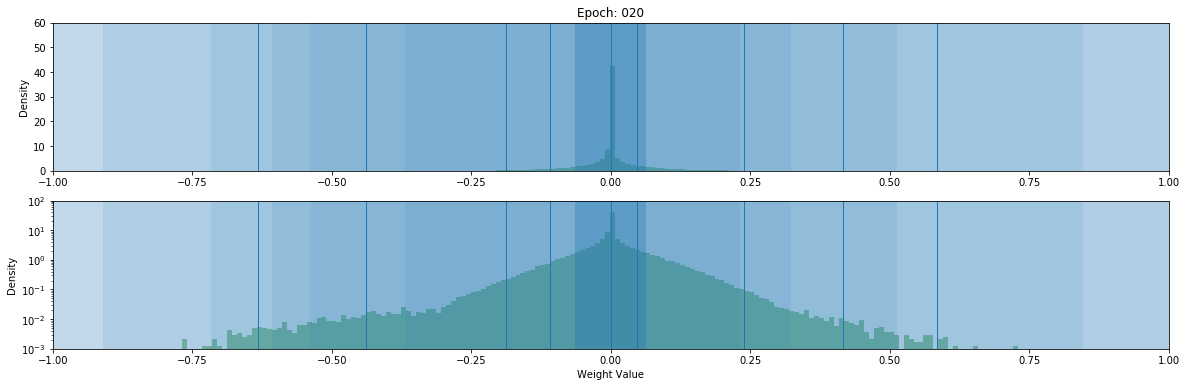

Epoch: 30. Test Accuracy: 98.16


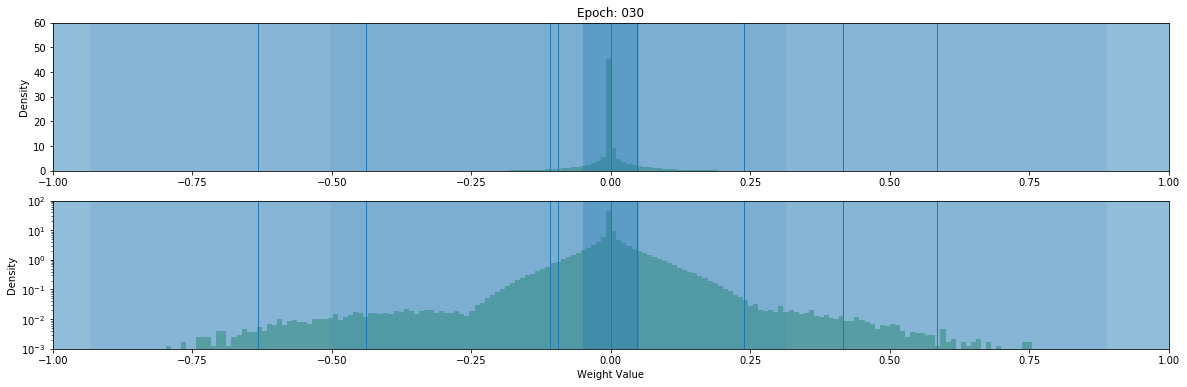

Epoch: 40. Test Accuracy: 98.21


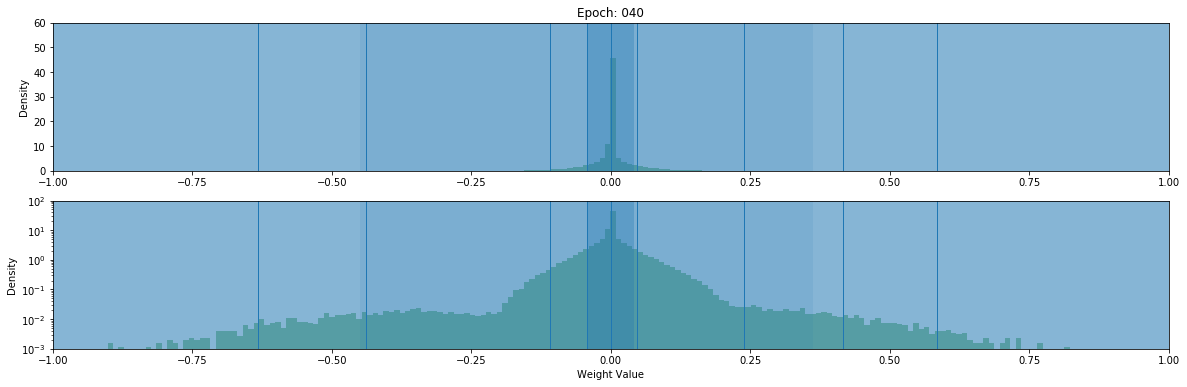

Epoch: 50. Test Accuracy: 98.22


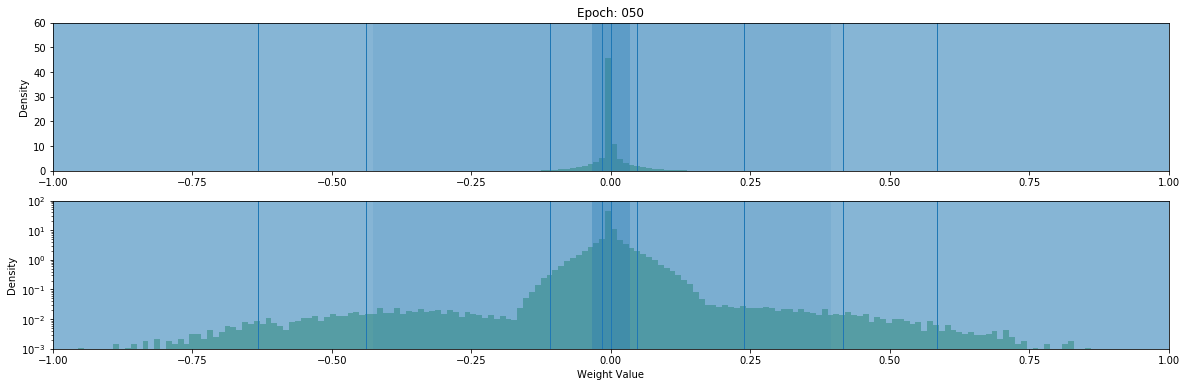

Retrain Test: 98.22, Retrain Validation: 98.19, Prune Test: 95.46, Prune Validation: 95.30, Prune Sparsity: 80.59


In [5]:
for temp in [0, 1, 5, 10, 25]:
    print ("TEMP: {}".format(temp))
    model, gmp = retrain_model(alpha, beta, float(params['tau'][i]), float(temp), int(params['mixtures'][i]), 'LeNet_300_100', 'search', "", False)

TEMP: 0
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 98.02


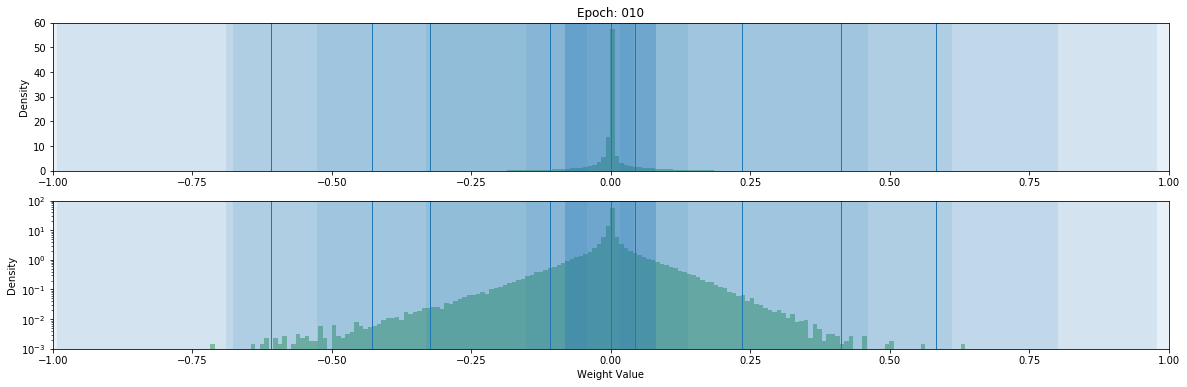

Epoch: 20. Test Accuracy: 97.70


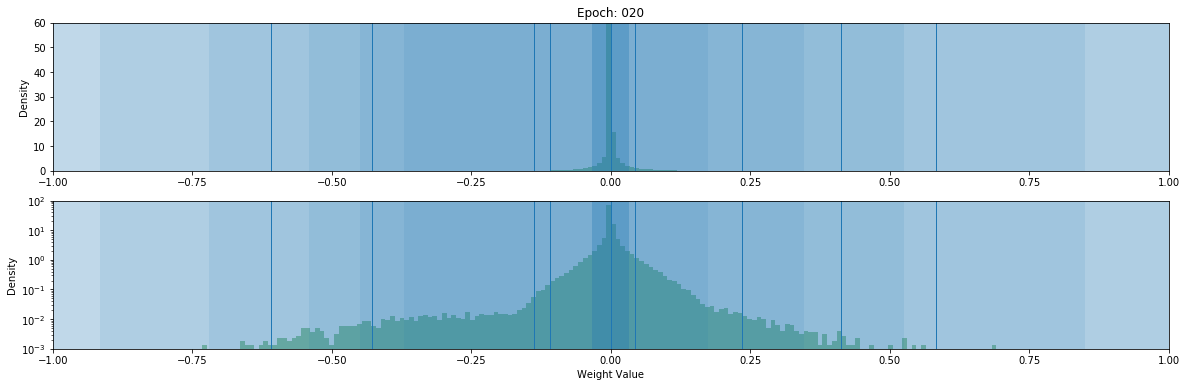

Epoch: 30. Test Accuracy: 97.18


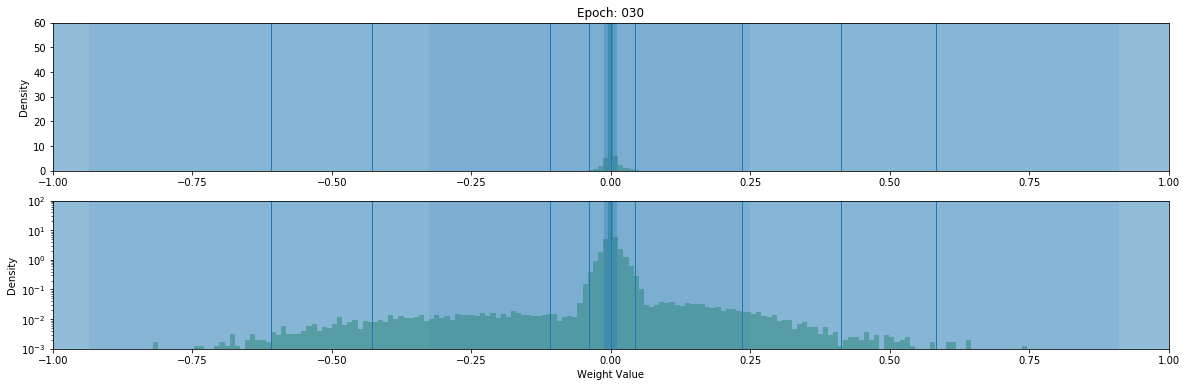

Epoch: 40. Test Accuracy: 96.48


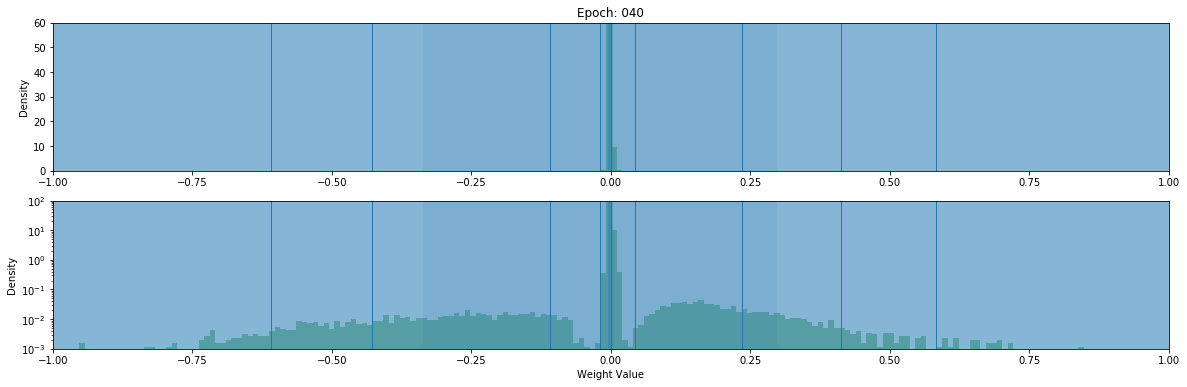

Epoch: 50. Test Accuracy: 96.75


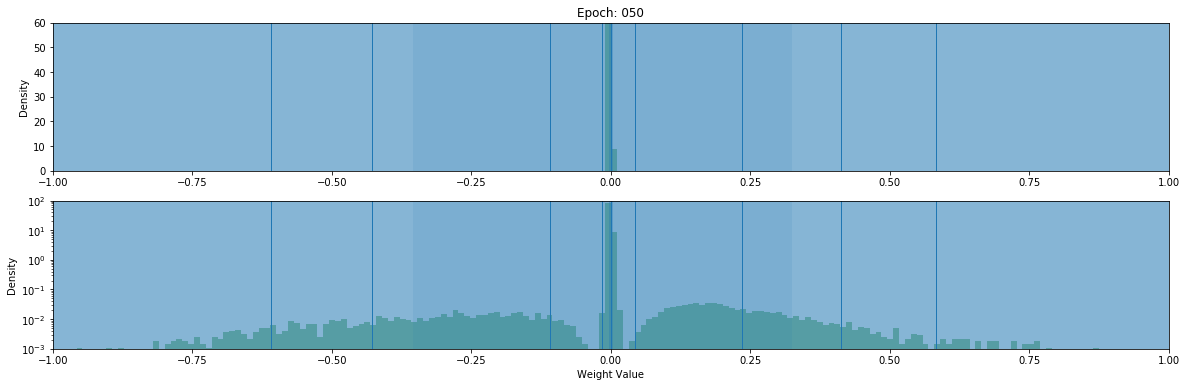

Retrain Test: 96.75, Retrain Validation: 96.39, Prune Test: 91.02, Prune Validation: 90.99, Prune Sparsity: 98.59
TEMP: 1
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 97.97


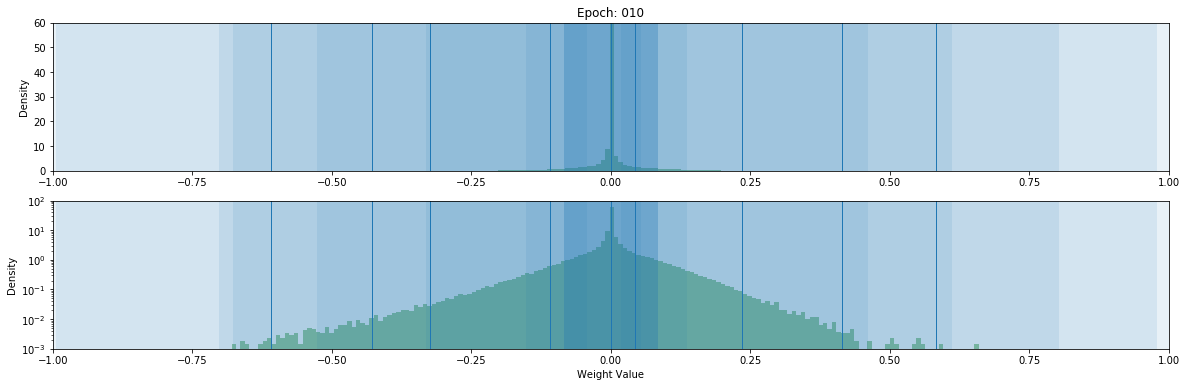

Epoch: 20. Test Accuracy: 98.01


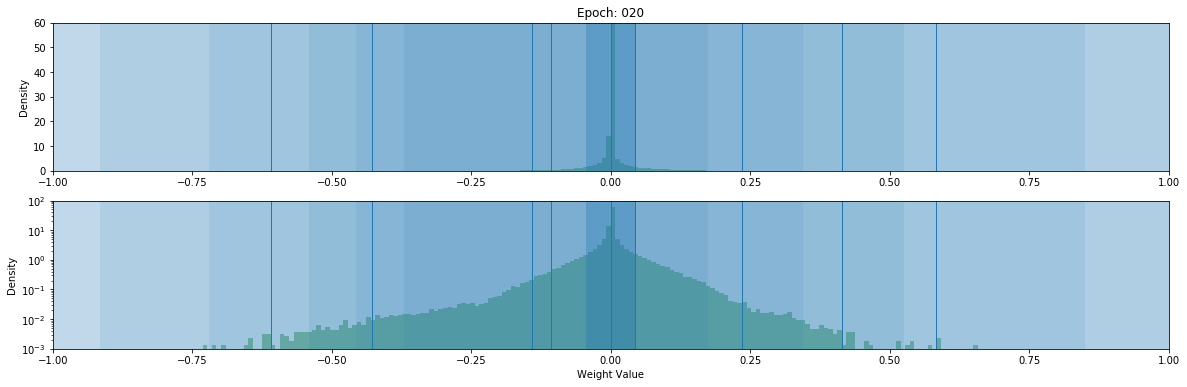

Epoch: 30. Test Accuracy: 97.55


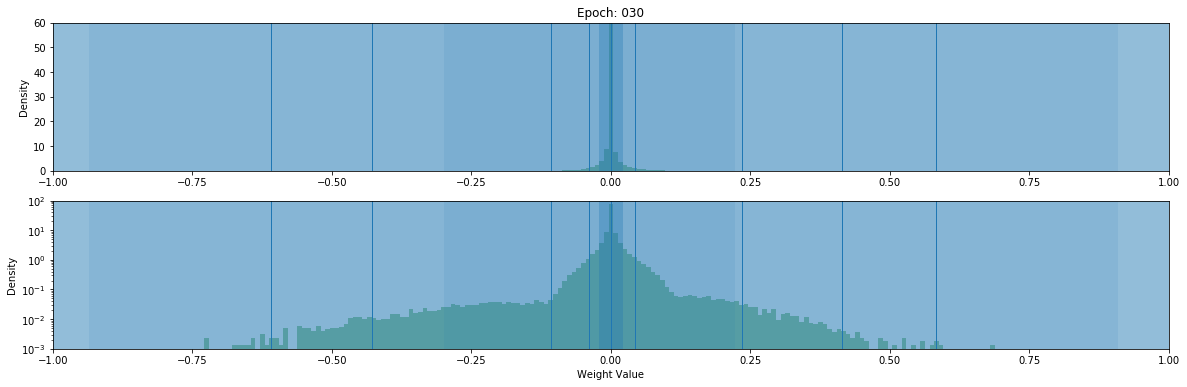

Epoch: 40. Test Accuracy: 97.15


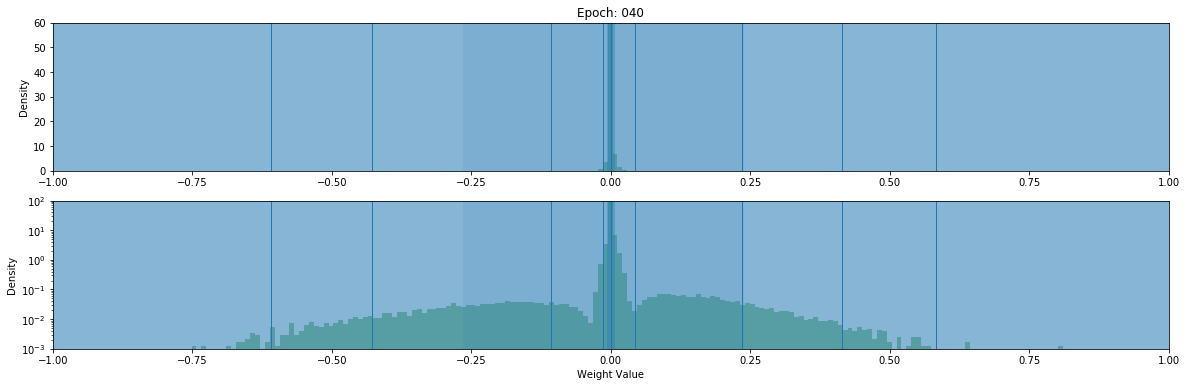

Epoch: 50. Test Accuracy: 96.82


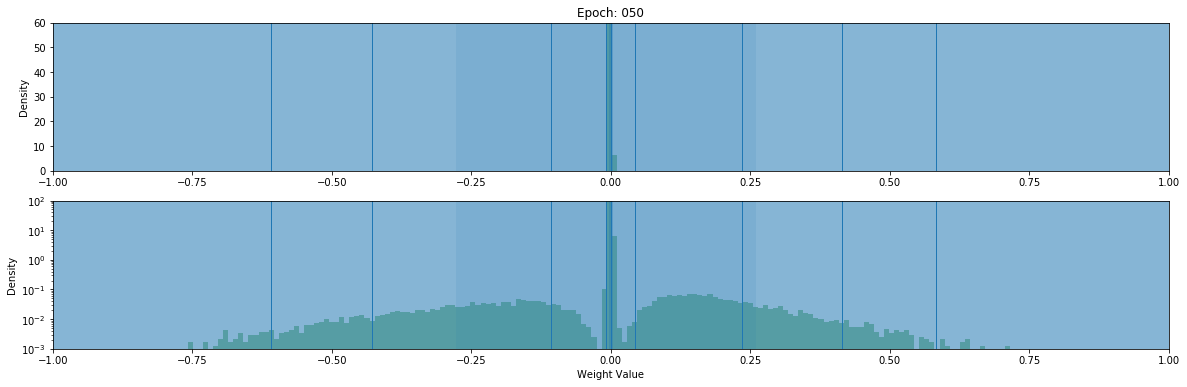

Retrain Test: 96.82, Retrain Validation: 96.92, Prune Test: 93.37, Prune Validation: 93.57, Prune Sparsity: 97.40
TEMP: 5
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 98.01


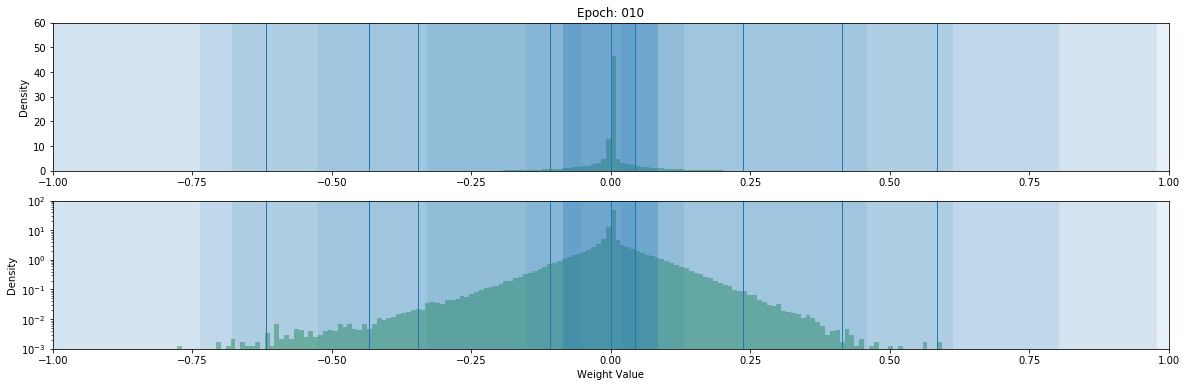

Epoch: 20. Test Accuracy: 97.71


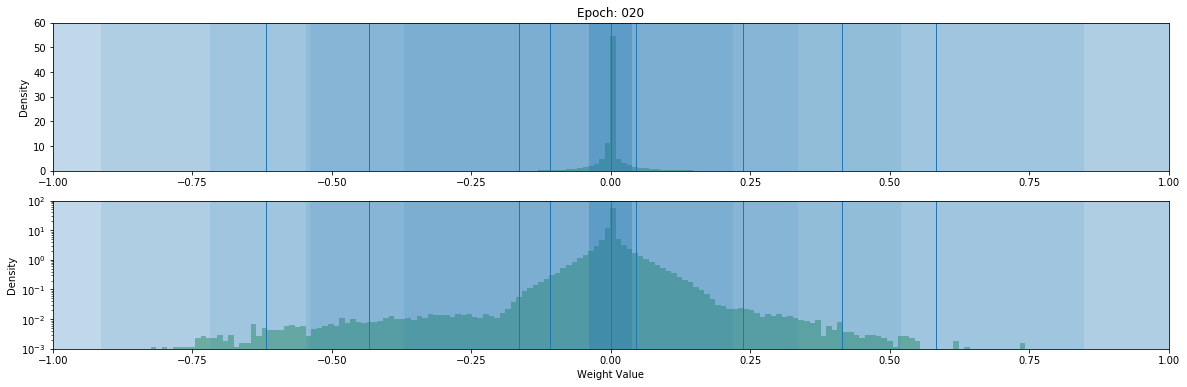

Epoch: 30. Test Accuracy: 97.59


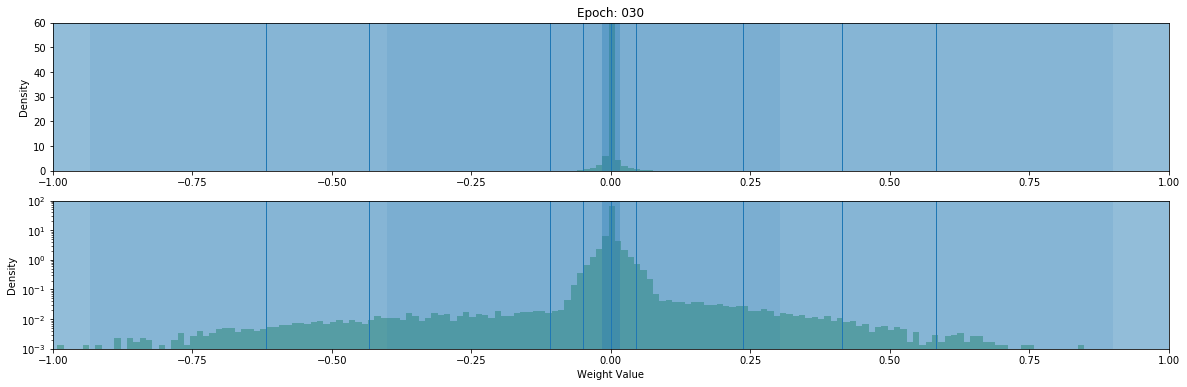

Epoch: 40. Test Accuracy: 96.79


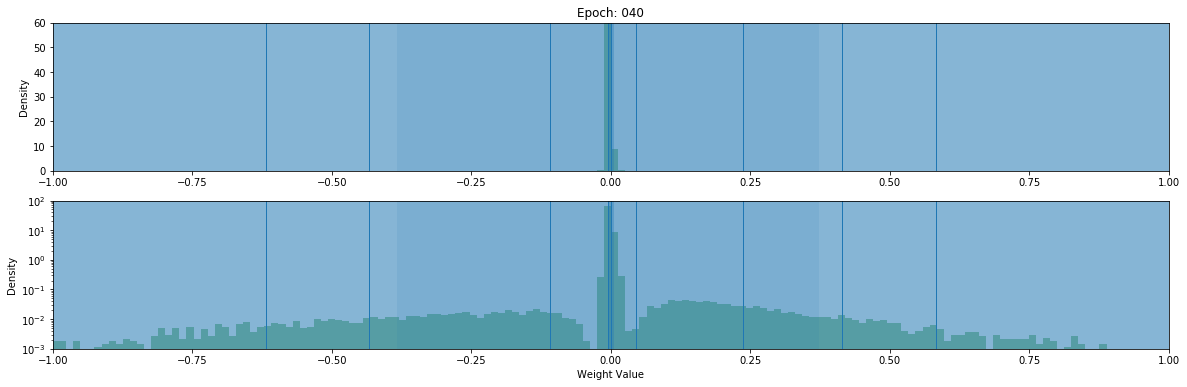

Epoch: 50. Test Accuracy: 96.94


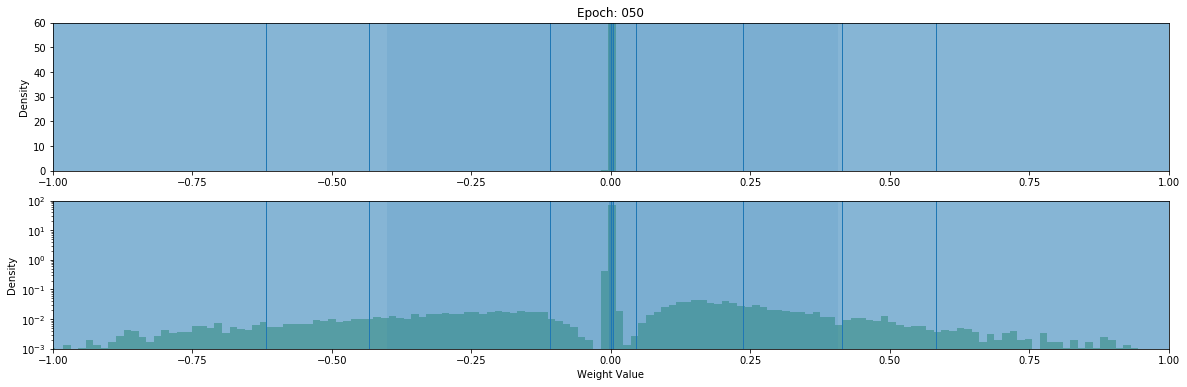

Retrain Test: 96.94, Retrain Validation: 96.70, Prune Test: 94.22, Prune Validation: 94.37, Prune Sparsity: 98.04
TEMP: 10
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 98.16


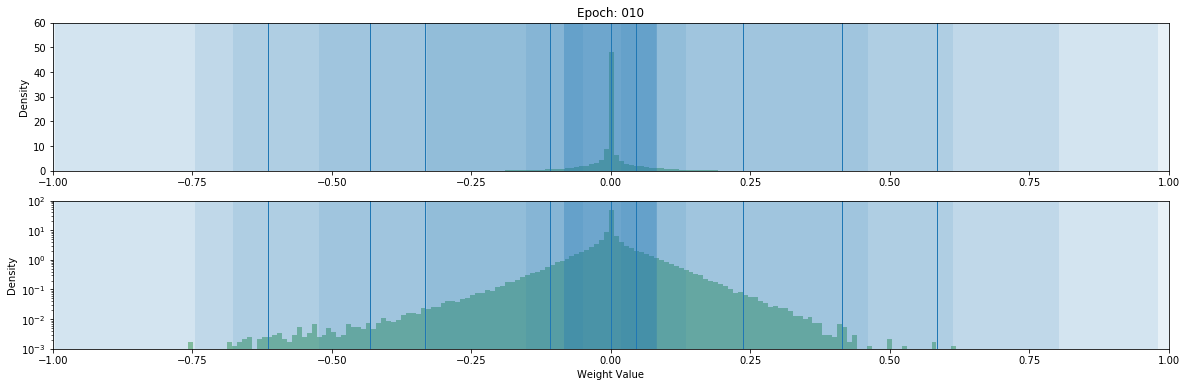

Epoch: 20. Test Accuracy: 97.85


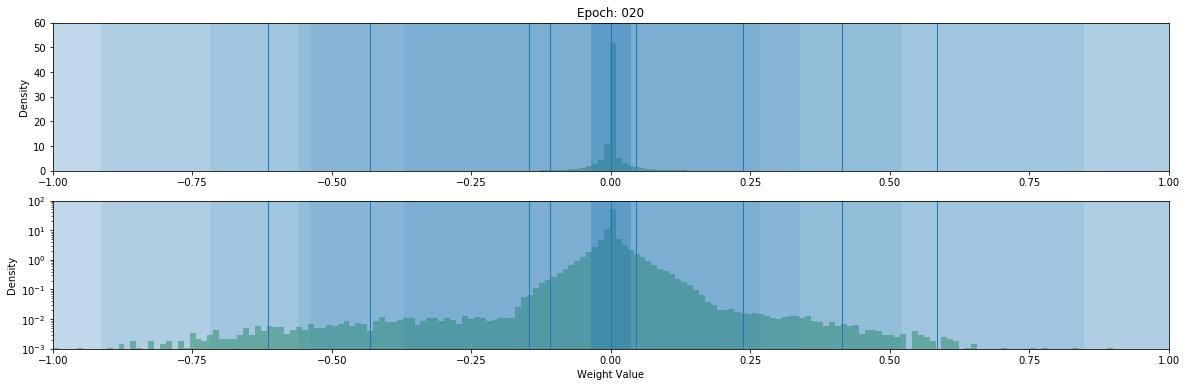

Epoch: 30. Test Accuracy: 97.52


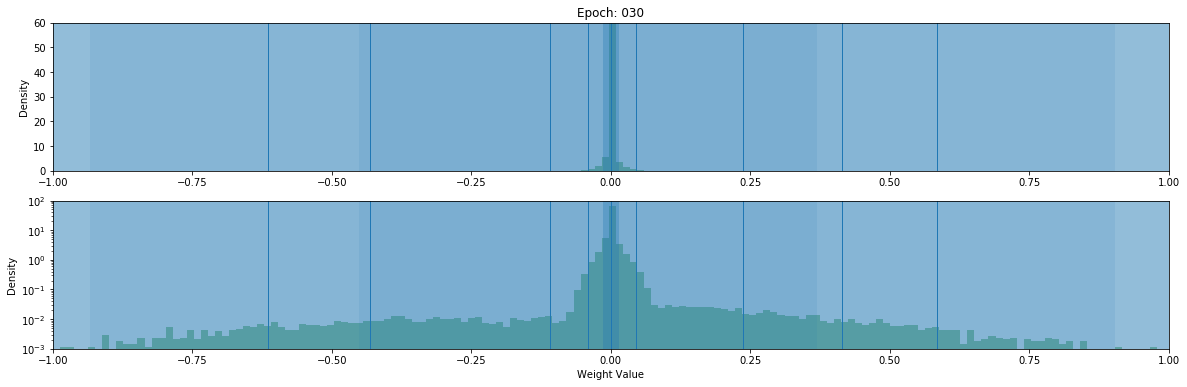

Epoch: 40. Test Accuracy: 97.10


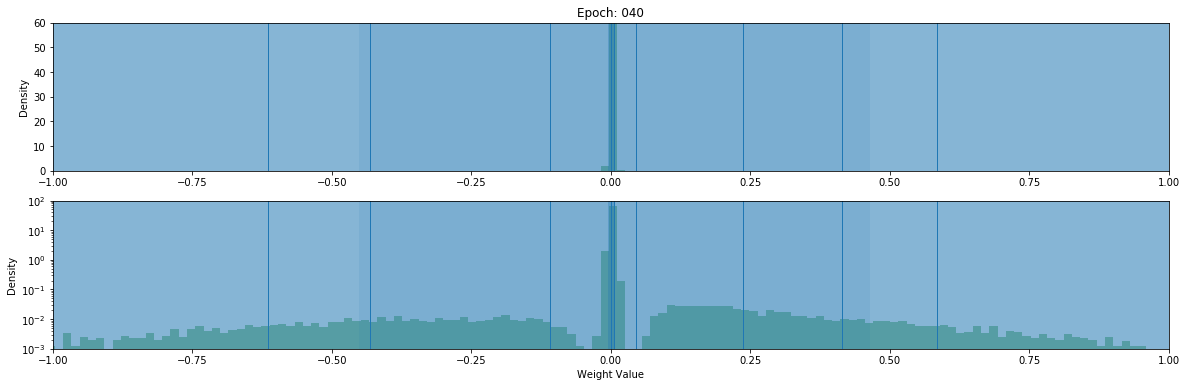

Epoch: 50. Test Accuracy: 97.16


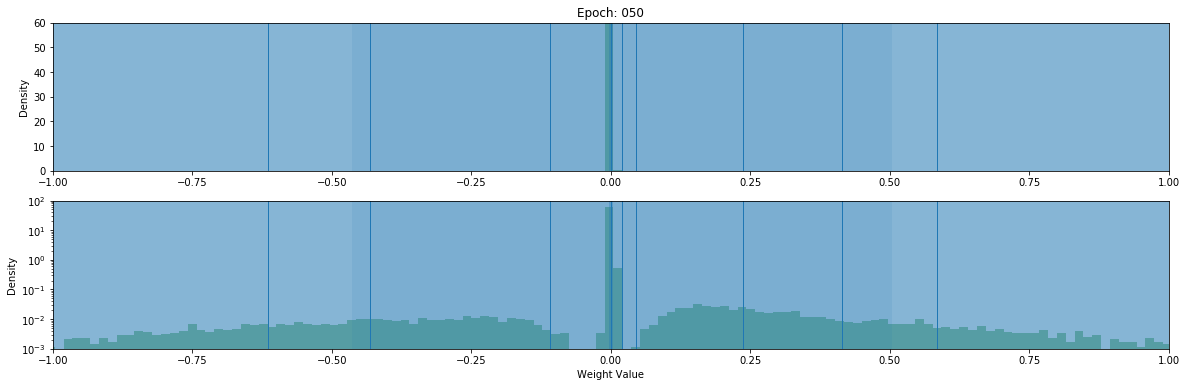

Retrain Test: 97.16, Retrain Validation: 97.00, Prune Test: 92.41, Prune Validation: 92.59, Prune Sparsity: 98.42
TEMP: 25
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225
Epoch: 10. Test Accuracy: 97.98


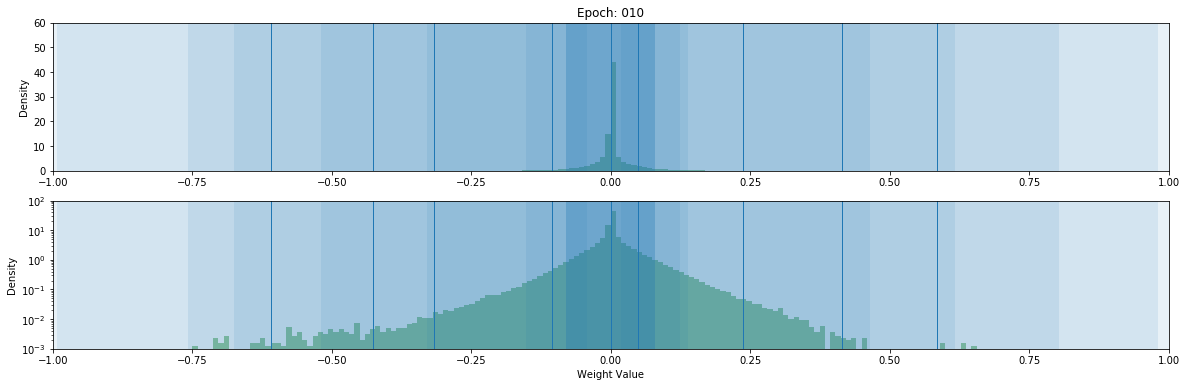

Epoch: 20. Test Accuracy: 97.25


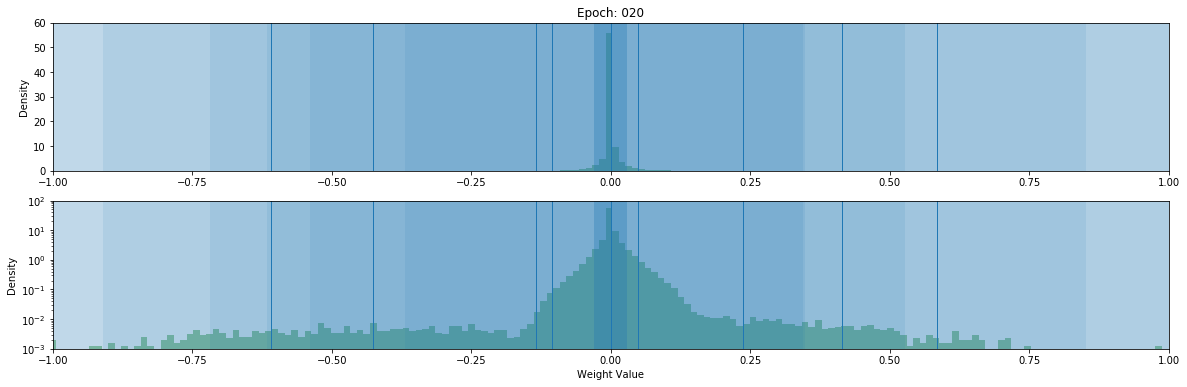

Epoch: 30. Test Accuracy: 95.73


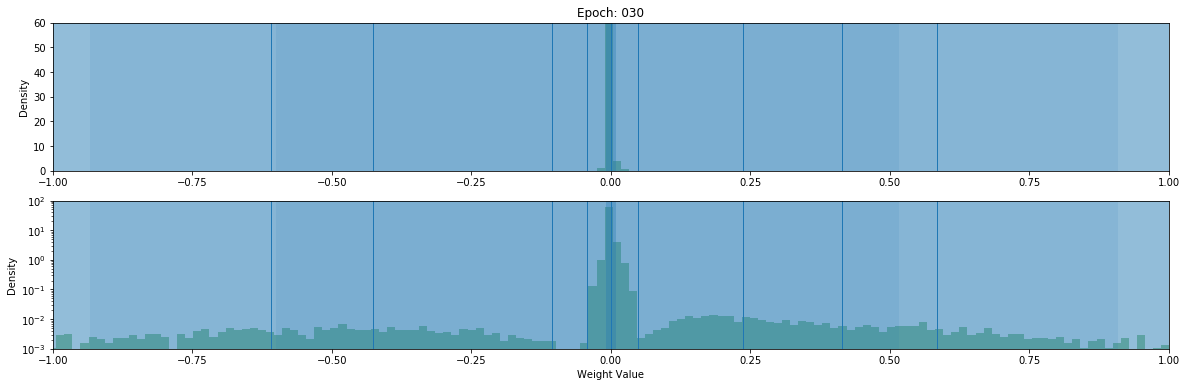

Epoch: 40. Test Accuracy: 95.10


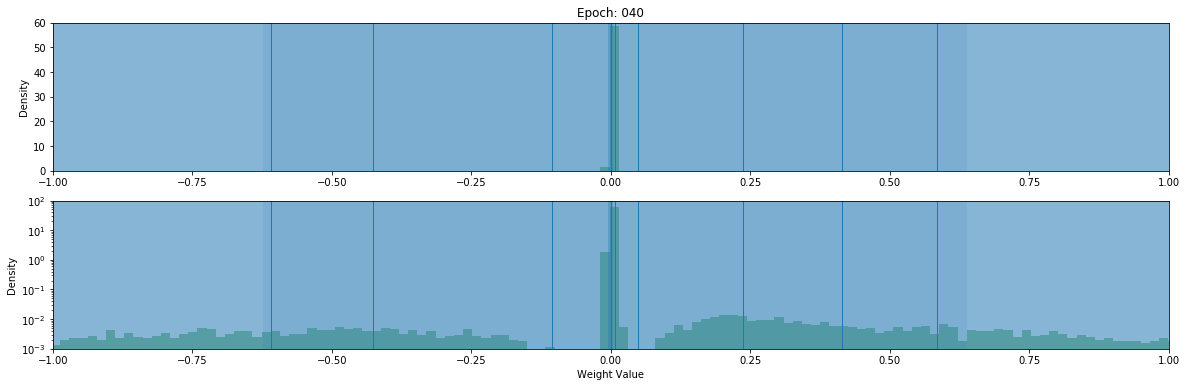

Epoch: 50. Test Accuracy: 95.16


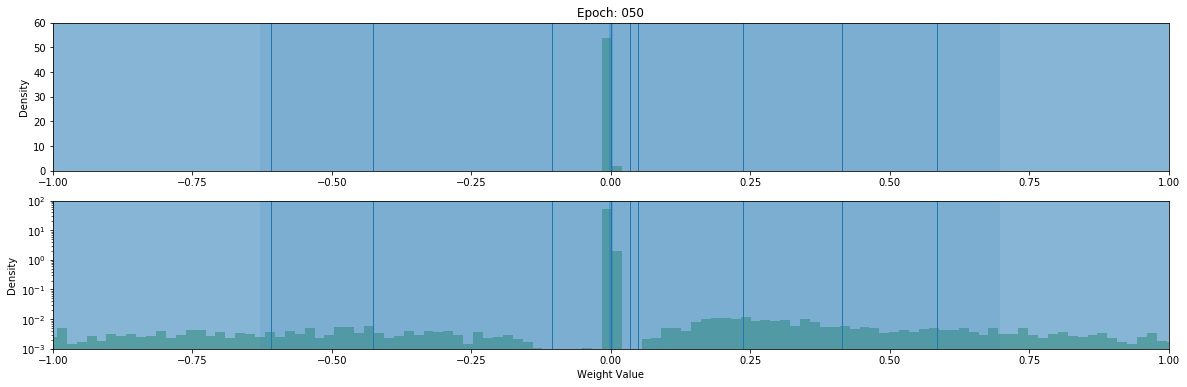

Retrain Test: 95.16, Retrain Validation: 95.41, Prune Test: 79.07, Prune Validation: 80.68, Prune Sparsity: 99.13


In [5]:
for temp in [0, 1, 5, 10, 25]:
    print ("TEMP: {}".format(temp))
    model, gmp = retrain_model(alpha, beta, float(params['tau'][i]), float(temp), int(params['mixtures'][i]), 'LeNet_300_100', 'search', "", False)